In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt 
from ChromaGAN import Generator, Discriminator, TinyImagenet, Trainer
import numpy as np
from tqdm import tqdm

In [2]:
data = TinyImagenet('/home/harsha/Downloads/tiny-imagenet-200')
datal = DataLoader(data, batch_size = 10, shuffle = True)

IndexError: index 10 is out of bounds for dimension 0 with size 10

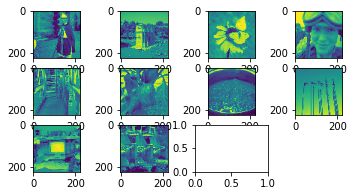

In [3]:
batch_idx, (example) = next(enumerate(datal))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(example['l'][i][0].numpy(),interpolation='none')

In [4]:
gen = Generator()

dis = Discriminator()


## Generator
print(gen)
## Discriminator
print(dis)

Generator(
  (vgg_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [5]:
trainer = Trainer(gen,dis,datal)

Device Name: GeForce GTX 1050 Ti


In [6]:
z = torch.randn(10,1,224,224)
out = trainer.generator(z.to(trainer.device))

torch.Size([10, 512, 28, 28])
torch.Size([10, 512, 10, 10])
torch.Size([10, 256, 28, 28])
torch.Size([10, 1000])
torch.Size([10, 256, 28, 28])


/home/harsha/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([10, 512, 28, 28])
torch.Size([10, 2, 224, 224])


In [7]:
out[1].size()

torch.Size([10, 2, 224, 224])